In [1]:
# Install PyTorch, PyTorch Lightning, and PyTorch Forecasting
!pip install pytorch-lightning
!pip install pytorch-forecasting
!pip install torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 22.5 MB/s eta 0:00:00


In [2]:
import torch
import pandas as pd
import numpy as np

In [3]:
data_train = pd.read_csv("/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/data/train_preprocessed.csv")

In [4]:
data_train.isna().sum()

,0
id,0
valeur_NO2,0
valeur_CO,0
valeur_O3,0
valeur_PM10,0
valeur_PM25,0
is_holiday,0
is_jour_ferie,0
precipitation,0
wind_speed,0


In [5]:
data_train.fillna(-1, inplace=True)

In [6]:
data_train["id"] = pd.to_datetime(data_train["id"])
features = ['id', 'is_holiday', 'car_flow', 'precipitation',
       'wind_speed', 'temperature', 'humidity', 'pressure', 'visibility',
       'global_solar_radiation', 'Year', 'is_weekend', 'DayOfYear',
       'HourOfDay', 'DayOfYear_sin', 'DayOfYear_cos', 'HourOfDay_sin',
       'HourOfDay_cos', 'Weekday_sin', 'Weekday_cos']
data_train["location"] = "Montsouris"
data_train['time_idx'] = ((data_train['id'] - data_train['id'].min()).dt.total_seconds() // 3600).astype("int")
data_train.head()

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,is_holiday,is_jour_ferie,precipitation,wind_speed,...,HourOfDay,Weekday,DayOfYear_sin,DayOfYear_cos,HourOfDay_sin,HourOfDay_cos,Weekday_sin,Weekday_cos,location,time_idx
0,2020-01-01 00:00:00,42.9,0.718000,15.7,73.1,64.4,1,0,0.0,1.5,...,0,2,0.017213,0.999852,0.000000,1.000000,0.974928,-0.222521,Montsouris,0
1,2020-01-01 01:00:00,33.6,0.587000,10.1,74.8,66.0,1,0,0.0,2.6,...,1,2,0.017213,0.999852,0.258819,0.965926,0.974928,-0.222521,Montsouris,1
2,2020-01-01 02:00:00,29.3,0.400655,5.1,51.0,44.9,1,0,0.0,1.9,...,2,2,0.017213,0.999852,0.500000,0.866025,0.974928,-0.222521,Montsouris,2
3,2020-01-01 03:00:00,30.5,0.246000,7.2,27.7,25.1,1,0,0.0,1.8,...,3,2,0.017213,0.999852,0.707107,0.707107,0.974928,-0.222521,Montsouris,3
4,2020-01-01 04:00:00,29.3,0.204000,8.3,15.3,13.6,1,0,0.0,2.2,...,4,2,0.017213,0.999852,0.866025,0.500000,0.974928,-0.222521,Montsouris,4


In [7]:
max_encoder_length = 7 * 24
max_prediction_length = 502  # Forecast 502 hours into the future

In [8]:
from pytorch_forecasting import TimeSeriesDataSet

In [9]:
# Step 1: Define the split point
split_idx = int(data_train['time_idx'].max() * 0.9)

# Step 2: Split into training and validation sets
train_data = data_train[data_train["time_idx"] <= split_idx]
test_data = data_train[data_train["time_idx"] > split_idx]

features.remove("car_flow")

# Step 3: Create TimeSeriesDataSets for train and validation
train_dataset = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target=["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"],
    group_ids=["location"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25", "car_flow"],
    time_varying_known_reals=features,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

val_dataset = TimeSeriesDataSet(
    test_data,
    time_idx="time_idx",
    target=["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"],
    group_ids=["location"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25", "car_flow"],
    time_varying_known_reals=features,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [53]:
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=64, num_workers=8)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=64, num_workers=8)

In [13]:
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting.metrics import MAE

# Define TFT model
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=0.03,  # You may adjust this
    hidden_size=16,  # Size of the network layers
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=[1, 1, 1, 1, 1],
    loss=MAE(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in model: {tft.size()/1e3:.1f}k")


Number of parameters in model: 53.1k


In [16]:
from lightning.pytorch import loggers as pl_loggers

tb_logger = pl_loggers.TensorBoardLogger(save_dir="/content/drive/MyDrive/lighting_logs")


In [18]:
from lightning.pytorch import Trainer

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but StandardScaler was fitted with feature names")

trainer = Trainer(max_epochs=5,logger=tb_logger)
trainer.fit(tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers       

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [19]:
prediction = tft.predict(val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [32]:
prediction[0].shape

torch.Size([3430, 502])

In [39]:
last_prediction = [prediction[i][-1,:] for i in range(5)]
last_prediction

[tensor([13.8505, 10.7575, 10.4703, 10.2942, 12.6086, 16.2511, 16.7508, 17.7178,
         14.0297, 13.2902, 11.5846,  9.6442,  9.3990,  8.6603,  8.9370, 11.1572,
         12.1548, 11.9055, 13.1380, 15.0414, 13.9527, 11.9226, 11.2415,  8.9433,
          8.2170,  7.9840,  8.6586,  9.7583, 11.6827, 12.2100, 13.1519, 13.3922,
         11.5075,  9.6411,  8.1581,  7.4309,  7.4044,  7.6221,  8.2877,  8.4215,
          9.8227, 11.9875, 14.8481, 18.8723, 15.6241, 12.4492, 12.8337, 14.7711,
         13.2792, 10.5175, 11.5058, 14.1790, 16.9520, 18.0114, 16.4671, 15.6805,
         13.2012,  9.7106,  9.4175,  8.5843,  7.7523,  8.5087,  9.8295, 10.5360,
         11.8602, 12.7045, 11.8965, 11.2557,  9.6089,  9.3601,  8.4676,  6.9205,
          6.6301,  6.5934,  7.0617,  6.8624,  8.5472, 11.0569, 11.2291, 10.3968,
         10.1933, 10.3292, 10.2470, 10.1859, 11.9273, 11.6174, 12.4110, 13.7063,
         17.2966, 16.9601, 16.6358, 13.4251, 11.0447, 10.0253,  6.5990,  6.3508,
          6.1763,  5.6684,  

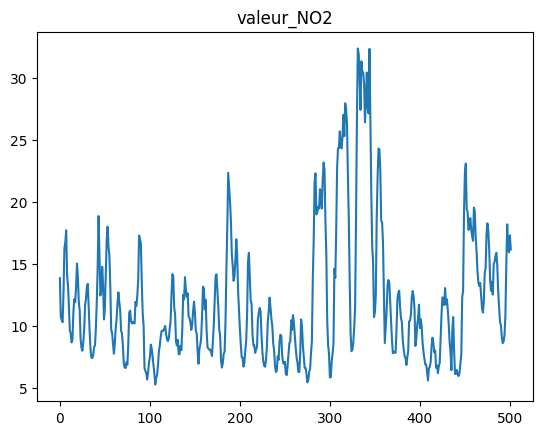

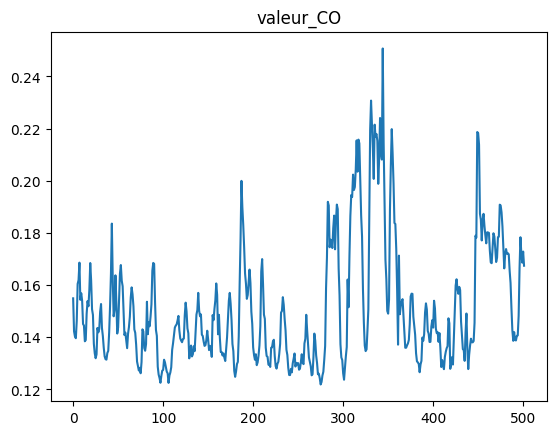

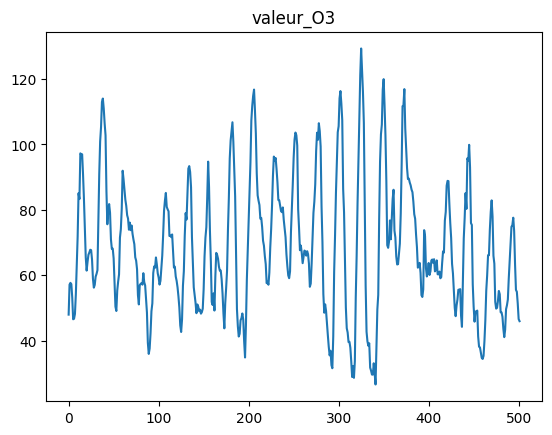

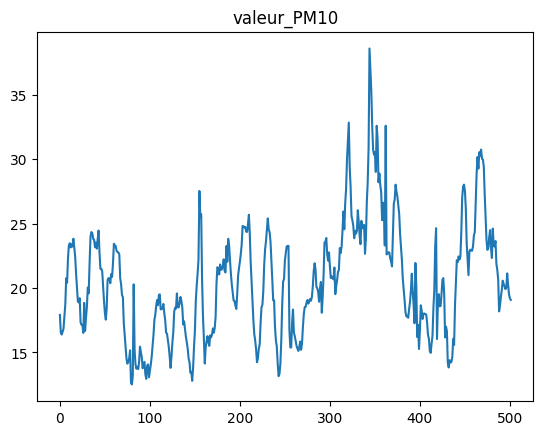

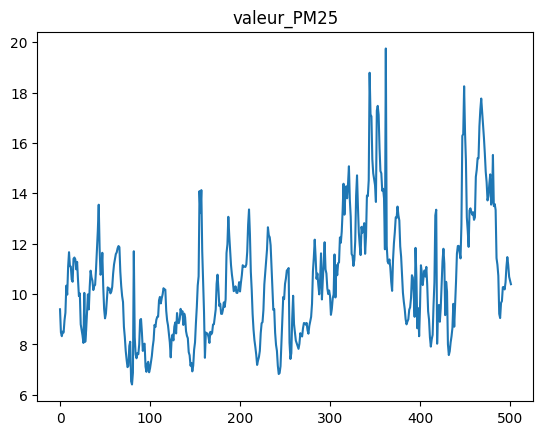

In [40]:
from matplotlib import pyplot as plt

targets = ["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"]

for i, element in enumerate(last_prediction):
  plt.plot(element.cpu().numpy())
  plt.title(targets[i])
  plt.show()

In [58]:
full_train_data = TimeSeriesDataSet(
    data_train,
    time_idx="time_idx",
    target=["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"],
    group_ids=["location"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"],
    time_varying_known_reals=features,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

full_train_dataloader = full_train_data.to_dataloader(train=True, batch_size=64, num_workers=8)
trainer = Trainer(max_epochs=3,logger=tb_logger)
# Resume training with the new combined dataloader
trainer.fit(tft,
            train_dataloaders=full_train_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/lighting_logs/lightning_logs/version_0/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
-

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [65]:
torch.save(tft.state_dict(), "/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/tft.json")

In [ ]:
prediction = tft.predict(full_train_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


In [ ]:
last_prediction = [prediction[i][-1,:] for i in range(5)]
last_prediction

In [63]:
new_data = pd.read_csv("/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/data/test_preprocessed.csv")
new_data["id"] = pd.to_datetime(new_data["id"])
new_data["location"] = "Montsouris"
new_data['time_idx'] = ((new_data['id'] - new_data['id'].min()).dt.total_seconds() // 3600).astype("int") + data_train["time_idx"].max()

prediction_dataset = TimeSeriesDataSet(
    new_data,  # Future data with known covariates only
    time_idx="time_idx",
    group_ids=["group_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=features,
    add_relative_time_idx=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,  # Allow missing target values in the future
)
prediction_dataloader = prediction_dataset.to_dataloader(train=False, batch_size=1)  # Prediction mode
future_predictions = tft.predict(prediction_dataloader)

TypeError: TimeSeriesDataSet.__init__() missing 1 required positional argument: 'target'

In [ ]:
submission = clean_for_submission(predicted_values_wide)
submission.to_csv("/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/submissions/matt_autogluon_features_2.csv", index=False)